In [ ]:
# Step 1: Create the target folders first
!mkdir -p /content/train/Benign
!mkdir -p /content/train/Malignant

# Step 2: Unzip into them using correct filenames
!unzip -q zipped-train-Benign.zip -d /content/train/Benign
!unzip -q zipped-train-Malignant.zip -d /content/train/Malignant

unzip:  cannot find or open zipped-train-Benign.zip, zipped-train-Benign.zip.zip or zipped-train-Benign.zip.ZIP.
unzip:  cannot find or open zipped-train-Malignant.zip, zipped-train-Malignant.zip.zip or zipped-train-Malignant.zip.ZIP.


In [ ]:
import glob

Benign_imgs = glob.glob('/content/train/Benign/*.jpg')
Malignant_imgs = glob.glob('/content/train/Malignant/*.jpg')

print(f"✅ Benign images found: {len(Benign_imgs)}")
print(f"✅ Malignant images found: {len(Malignant_imgs)}")

✅ Benign images found: 700
✅ Malignant images found: 700


In [ ]:
import os
import cv2
from glob import glob
from tqdm import tqdm
import albumentations as A

# Define input and output directories
input_dir = '/content/train'
aug_dir = '/content/train_augmented'

# Create output folders
os.makedirs(f'{aug_dir}/Benign', exist_ok=True)
os.makedirs(f'{aug_dir}/Malignant', exist_ok=True)

# Augmentation pipeline
augment = A.Compose([
    A.Rotate(limit=15, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.Resize(224, 224)
])

# Function to augment a class
def augment_images(class_type):
    image_paths = glob(f'{input_dir}/{class_type}/*.jpg')  # or .png
    for path in tqdm(image_paths, desc=f"Augmenting {class_type}"):
        try:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            base_name = os.path.splitext(os.path.basename(path))[0]

            for i in range(3):  # Create 3 augmented versions
                aug_img = augment(image=img)['image']
                aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
                save_path = f'{aug_dir}/{class_type}/{base_name}_aug{i}.jpg'
                cv2.imwrite(save_path, aug_img)

        except Exception as e:
            print(f"⚠️ Error processing {path}: {e}")

# Run for both classes
augment_images('Benign')
augment_images('Malignant')

Augmenting Malignant: 100%|██████████| 700/700 [00:03<00:00, 206.33it/s]


In [ ]:
import shutil

# Final folder to hold all training data
final_train_dir = '/content/final_train_data'
os.makedirs(f'{final_train_dir}/Benign', exist_ok=True)
os.makedirs(f'{final_train_dir}/Malignant', exist_ok=True)

# Copy original Benign and Malignant
for path in glob('/content/train/Benign/*.jpg'):
    shutil.copy(path, f'{final_train_dir}/Benign/')

for path in glob('/content/train/Malignant/*.jpg'):
    shutil.copy(path, f'{final_train_dir}/Malignant/')

# Copy augmented Benign and Malignant
for path in glob('/content/train_augmented/Benign/*.jpg'):
    shutil.copy(path, f'{final_train_dir}/Benign/')

for path in glob('/content/train_augmented/Malignant/*.jpg'):
    shutil.copy(path, f'{final_train_dir}/Malignant/')

print("✅ All original + augmented images are merged into 'final_train_data/'")


✅ All original + augmented images are merged into 'final_train_data/'


In [ ]:
import glob

# Final training folders
Benign_images = glob.glob('/content/final_train_data/Benign/*.jpg')
Malignant_images = glob.glob('/content/final_train_data/Malignant/*.jpg')

# Count
print(f"✅ Total Benign (healthy) Images: {len(Benign_images)}")
print(f"✅ Total Malignant (sick) Images: {len(Malignant_images)}")
print(f"🟢 Total Training Images: {len(Benign_images) + len(Malignant_images)}")

✅ Total Benign (healthy) Images: 2800
✅ Total Malignant (sick) Images: 2800
🟢 Total Training Images: 5600


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Basic image transformation and resizing for ResNet input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load images from final_train_data/Benign & Malignant
dataset = datasets.ImageFolder('/content/final_train_data', transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Class names
print("Classes:", dataset.classes)  # Should show ['Benign', 'Malignant']

Classes: ['Benign', 'Malignant']


In [ ]:
!pip install timm --quiet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
num_epochs = 5
learning_rate = 1e-4
num_classes = 2  # Benign, Malignant

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = datasets.ImageFolder('/content/final_train_data', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over all batches
    for images, labels in dataloader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Track training statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Calculate epoch averages
    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2f}%")
    print("-" * 50)  # Separator between epochs

print("Training completed successfully!")

Epoch 1/5 - Loss: 0.5264 - Accuracy: 72.96%
--------------------------------------------------
Epoch 2/5 - Loss: 0.2066 - Accuracy: 91.96%
--------------------------------------------------
Epoch 3/5 - Loss: 0.0893 - Accuracy: 96.95%
--------------------------------------------------
Epoch 4/5 - Loss: 0.0809 - Accuracy: 97.34%
--------------------------------------------------
Epoch 5/5 - Loss: 0.0694 - Accuracy: 97.43%
--------------------------------------------------
Training completed successfully!


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
full_dataset = datasets.ImageFolder('/content/train', transform=transform)

In [ ]:
train_size = int(0.8 * len(full_dataset))  # 80%
val_size = len(full_dataset) - train_size  # 20%

In [ ]:
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

val_accuracy = evaluate(model, val_loader, device)
print(f"🟢 Validation Accuracy: {val_accuracy:.2f}%")

🟢 Validation Accuracy: 99.64%


In [ ]:
torch.save(model.state_dict(), 'vit_breast_model.pth')
print("✅ Model saved!")

✅ Model saved!


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import numpy as np
from tqdm import tqdm
import os

# GPU check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)

vit_model.to(device)
vit_model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])

dataset = datasets.ImageFolder('/content/train', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [ ]:
all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        features = vit_model.forward_features(images)  # [B, 768]
        all_features.append(features.cpu())
        all_labels.append(labels)

all_features = torch.cat(all_features).numpy()
all_labels = torch.cat(all_labels).numpy()

print("✅ Features shape:", all_features.shape)
print("✅ Labels shape:", all_labels.shape)

100%|██████████| 44/44 [00:06<00:00,  6.30it/s]


✅ Features shape: (1400, 197, 768)
✅ Labels shape: (1400,)


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTModel, ViTFeatureExtractor
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dir = "/content/train_augmented"
train_dataset = ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
vit_model.eval()
vit_model.to(device)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [ ]:
import numpy as np

all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        inputs = feature_extractor(images=images, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = vit_model(**inputs)
        # Take [CLS] token as feature vector
        features = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())

# Combine results
X = np.concatenate(all_features)
y = np.concatenate(all_labels)

100%|██████████| 132/132 [00:33<00:00,  3.97it/s]


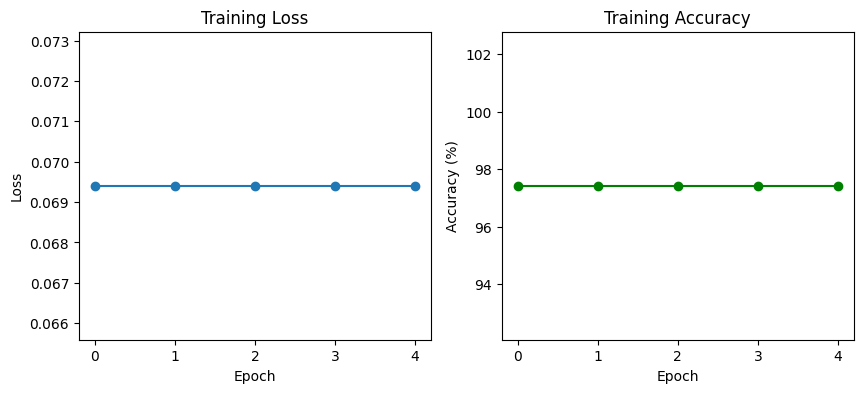

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    ...
    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

# Plot loss and accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_accuracies, marker='o', color="green")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.show()

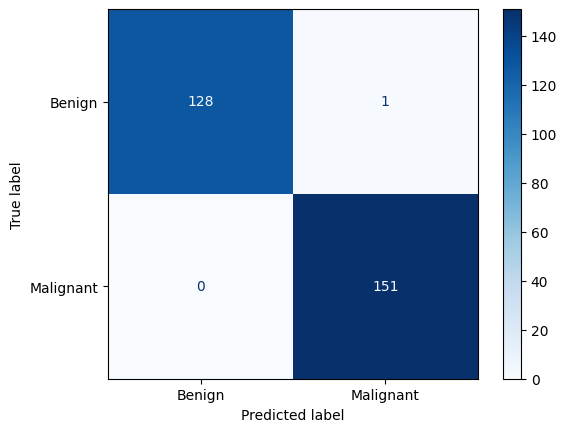

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

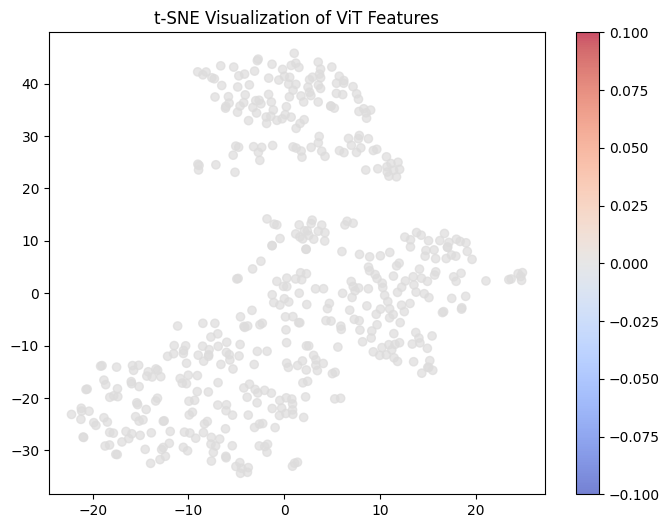

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert list of features/labels to numpy arrays
X = np.vstack(all_features)   # Stack features into a single array
y = np.hstack(all_labels)     # Stack labels into a single array

# Take a sample to speed up TSNE computation (e.g., first 500 samples)
X_sample = X[:500]
y_sample = y[:500]

# Initialize TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

# Fit TSNE on the sampled features
X_2d = tsne.fit_transform(X_sample)

# Plot the 2D embedding
plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=y_sample, cmap="coolwarm", alpha=0.7)
plt.colorbar()
plt.title("t-SNE Visualization of ViT Features")
plt.show()

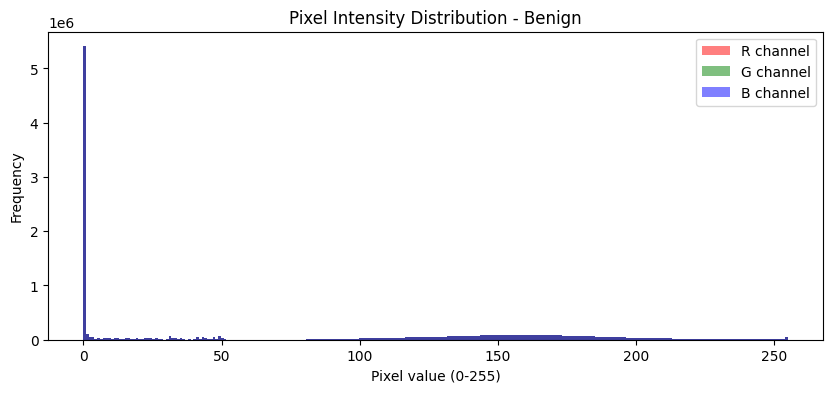

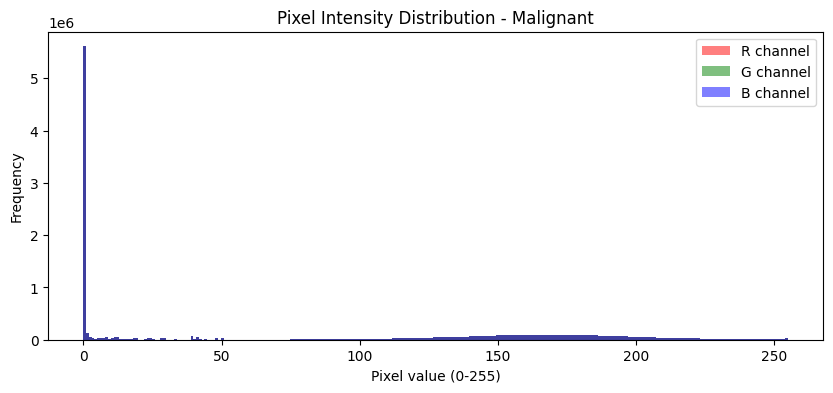

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

# Define class folders
classes = ['Benign', 'Malignant']
base_dir = '/content/final_train_data'

for cls in classes:
    # Get list of images for the class
    img_paths = glob(f'{base_dir}/{cls}/*.jpg')

    # Initialize arrays to hold pixel values
    all_r, all_g, all_b = [], [], []

    for path in img_paths[:200]:  # Use a sample to speed up plotting
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
        all_r.extend(r.flatten())
        all_g.extend(g.flatten())
        all_b.extend(b.flatten())

    # Plot histograms
    plt.figure(figsize=(10,4))
    plt.hist(all_r, bins=256, color='red', alpha=0.5, label='R channel')
    plt.hist(all_g, bins=256, color='green', alpha=0.5, label='G channel')
    plt.hist(all_b, bins=256, color='blue', alpha=0.5, label='B channel')
    plt.title(f'Pixel Intensity Distribution - {cls}')
    plt.xlabel('Pixel value (0-255)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [ ]:
misclassified = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))

print(f"Number of misclassified images: {len(misclassified)}")


Number of misclassified images: 1


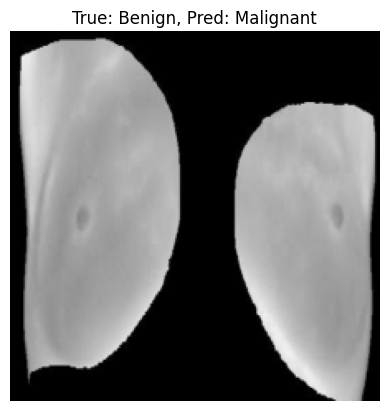

In [ ]:
import matplotlib.pyplot as plt

# Show misclassified images
for img, true_label, pred_label in misclassified:
    img = img.permute(1, 2, 0)  # C,H,W -> H,W,C
    # Unnormalize
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.numpy().clip(0,1)

    plt.imshow(img)
    plt.title(f"True: {dataset.classes[true_label]}, Pred: {dataset.classes[pred_label]}")
    plt.axis('off')
    plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch

# ----- Prepare lists for true and predicted labels -----
all_true = []
all_pred = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:  # val_loader هو DataLoader للـ validation set
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())

# ----- Metrics -----
acc = accuracy_score(all_true, all_pred)
prec = precision_score(all_true, all_pred, average=None)  # لكل class
rec = recall_score(all_true, all_pred, average=None)
f1 = f1_score(all_true, all_pred, average=None)

print(f"✅ Validation Accuracy: {acc*100:.2f}%")
for i, class_name in enumerate(dataset.classes):
    print(f"Class: {class_name}")
    print(f"  Precision: {prec[i]:.2f}")
    print(f"  Recall:    {rec[i]:.2f}")
    print(f"  F1-score:  {f1[i]:.2f}")

# ----- Confusion Matrix -----
cm = confusion_matrix(all_true, all_pred)
print("\nConfusion Matrix:")
print(cm)

# ----- Optional: Detailed classification report -----
print("\nClassification Report:")
print(classification_report(all_true, all_pred, target_names=dataset.classes))

✅ Validation Accuracy: 99.64%
Class: Benign
  Precision: 1.00
  Recall:    0.99
  F1-score:  1.00
Class: Malignant
  Precision: 0.99
  Recall:    1.00
  F1-score:  1.00

Confusion Matrix:
[[128   1]
 [  0 151]]

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      0.99      1.00       129
   Malignant       0.99      1.00      1.00       151

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280



In [ ]:
!pip install vit-pytorch --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 16.8 MB/s eta 0:00:00


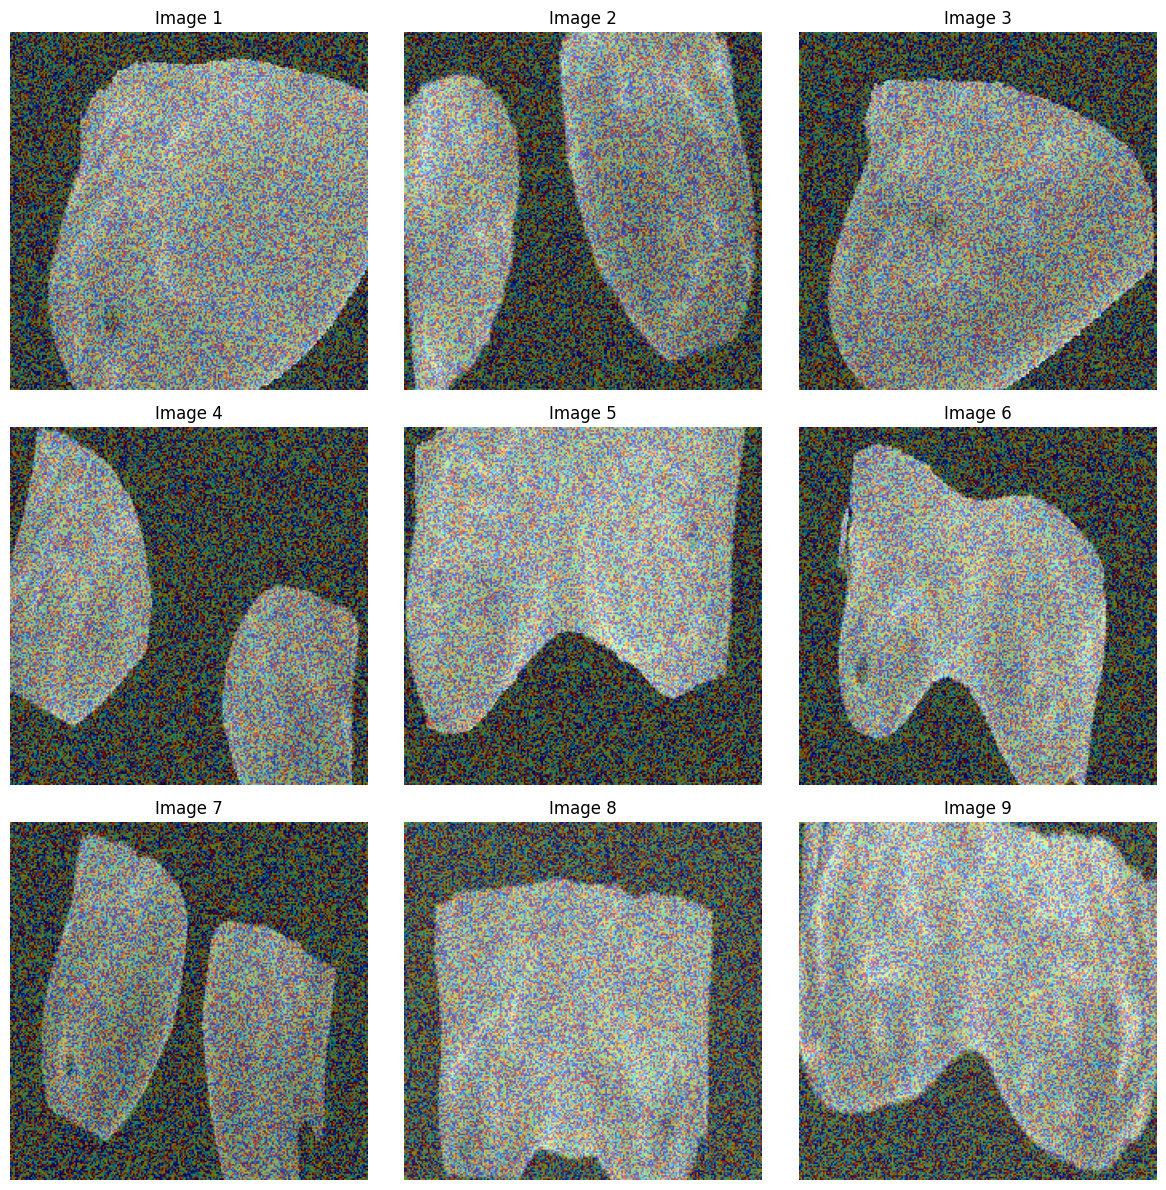

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import os
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# ----- Folder with images -----
image_dir = '/content/final_train_data/Benign'
all_images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg','.png'))]

# ----- Transformation -----
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# ----- Plot grid setup -----
n_images = min(9, len(all_images))  # show up to 9 images
fig, axes = plt.subplots(3,3, figsize=(12,12))

for i in range(n_images):
    img = Image.open(all_images[i]).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    # ----- Attention/GradCAM placeholder -----
    # Replace with your real attention map computation
    attn_map = np.random.rand(224,224)  # example random map

    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.imshow(attn_map, cmap='jet', alpha=0.5)
    ax.axis('off')
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

In [ ]:
import os
from glob import glob
import torch
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
import timm
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------------
# 1️⃣ Paths
data_dir = "/content/final_train_data"
train_dir = "/content/train_augmented"
test_dir = "/content/test_augmented"

# -------------------------------
# 2️⃣ Transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# -------------------------------
# 3️⃣ Load full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)

# Split indices for test (20%) and remaining (80% for train+val)
train_val_indices, test_indices = train_test_split(
    list(range(len(full_dataset))),
    test_size=0.2,
    stratify=full_dataset.targets,
    random_state=42
)

# Datasets
train_val_dataset = Subset(full_dataset, train_val_indices)
test_dataset = Subset(datasets.ImageFolder(data_dir, transform=test_transform), test_indices)

# Split train_val_dataset into train (80%) and val (20% of train_val)
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# -------------------------------
# 4️⃣ ViT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2

model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# -------------------------------
# 5️⃣ Training
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2f}%")

# -------------------------------
# 6️⃣ Validation accuracy
def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

val_acc = evaluate(val_loader)
print(f"Validation Accuracy: {val_acc:.2f}%")

# -------------------------------
# 7️⃣ Test accuracy + report
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * sum([p==l for p,l in zip(all_preds, all_labels)]) / len(all_labels)
print(f"✅ Test Accuracy: {test_acc:.2f}%")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Train samples: 3584
Validation samples: 896
Test samples: 1120
Epoch 1/5 - Loss: 0.6903 - Accuracy: 59.54%
Epoch 2/5 - Loss: 0.6012 - Accuracy: 67.44%
Epoch 3/5 - Loss: 0.4868 - Accuracy: 76.95%
Epoch 4/5 - Loss: 0.3951 - Accuracy: 82.31%
Epoch 5/5 - Loss: 0.2918 - Accuracy: 87.83%
Validation Accuracy: 88.06%
✅ Test Accuracy: 89.38%

Classification Report:
              precision    recall  f1-score   support

      Benign       0.87      0.92      0.90       560
   Malignant       0.92      0.87      0.89       560

    accuracy                           0.89      1120
   macro avg       0.89      0.89      0.89      1120
weighted avg       0.89      0.89      0.89      1120

Confusion Matrix:
[[516  44]
 [ 75 485]]


end vit


In [ ]:
from sklearn.model_selection import train_test_split
import torch

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([2940, 768])
X_val shape: torch.Size([630, 768])
X_test shape: torch.Size([630, 768])
y_train shape: torch.Size([2940])
y_val shape: torch.Size([630])
y_test shape: torch.Size([630])


In [ ]:
!pip install pykan --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 1.5 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from kan import KAN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_features, y_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


NameError: name 'X_features' is not defined

In [ ]:
train_dataset = TensorDataset(X_train.float(), y_train.long())
val_dataset   = TensorDataset(X_val.float(), y_val.long())
test_dataset  = TensorDataset(X_test.float(), y_test.long())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

NameError: name 'X_train' is not defined

In [ ]:
input_dim = X_train.shape[1]
hidden_size = 64
output_size = 2  # Benign / Malignant

# Create model on CPU only
model = KAN(width=[input_dim, hidden_size, output_size], grid=32)

AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
print("Unique labels:", labels.unique())

Unique labels: tensor([0, 1])


In [ ]:
# Set device
device = torch.device("cpu")

In [ ]:
# Optional: inspect model
print(model)

MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 100

X_train = X_train.to(device)
y_train = y_train.to(device)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        _, preds = torch.max(outputs, 1)
        acc = (preds == y_train).float().mean()
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f} - Train Acc: {acc*100:.2f}%")


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
print(inputs.shape)


torch.Size([32, 768])


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


dataset = datasets.ImageFolder('/content/final_train_data', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


print("🔹 Classes detected by ImageFolder:", dataset.classes)


model.load_state_dict(torch.load('vit_breast_model.pth', map_location=device))
model.eval()


correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"🟢 Accuracy with current class order: {accuracy:.2f}%")

if accuracy < 60:
    flipped_correct = (1 - torch.tensor(all_preds) == torch.tensor(all_labels)).sum().item()
    flipped_acc = 100 * flipped_correct / total
    print(f"🔄 Accuracy if classes are flipped: {flipped_acc:.2f}%")

🔹 Classes detected by ImageFolder: ['healthy', 'sick']
🟢 Accuracy with current class order: 96.86%


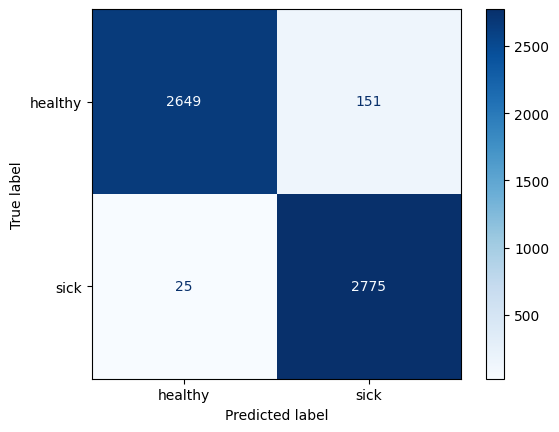

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=dataset.classes))

              precision    recall  f1-score   support

     healthy       0.99      0.95      0.97      2800
        sick       0.95      0.99      0.97      2800

    accuracy                           0.97      5600
   macro avg       0.97      0.97      0.97      5600
weighted avg       0.97      0.97      0.97      5600



In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np
import torch

model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]

        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

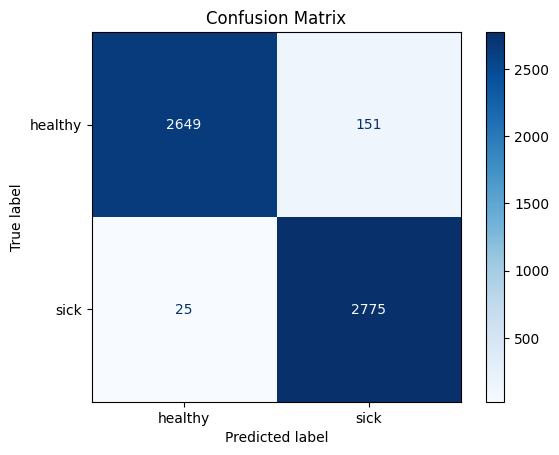

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

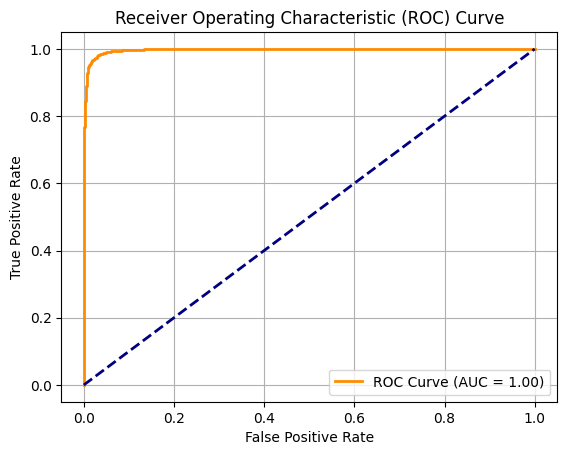

In [ ]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
from PIL import Image
import torch
from torchvision import transforms


img_path = '/content/final_train_data/healthy/H_30.jpg'


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    output = model(input_tensor)
    prob = torch.softmax(output, dim=1).cpu().numpy()[0]
    pred_class = prob.argmax()

print(f"✅ Expectation: {dataset.classes[pred_class]}")

for cls, p in zip(dataset.classes, prob):
    print(f"{cls}: {p:.4f}")


✅ Expectation: healthy
healthy: 0.9994
sick: 0.0006


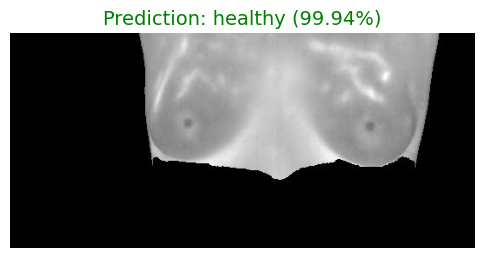

In [ ]:
import matplotlib.pyplot as plt



img_path = '/content/final_train_data/healthy/H_30.jpg'


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    output = model(input_tensor)
    prob = torch.softmax(output, dim=1).cpu().numpy()[0]
    pred_class = prob.argmax()

pred_label = dataset.classes[pred_class]
pred_prob = prob[pred_class] * 100


plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {pred_label} ({pred_prob:.2f}%)", fontsize=14, color='green')
plt.show()


In [ ]:
pip install gradio

In [ ]:
import gradio as gr
from PIL import Image
import torch
from torchvision import transforms


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


def predict(img):
    img = img.convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.softmax(output, dim=1).cpu().numpy()[0]
        pred_class = prob.argmax()
        return {dataset.classes[i]: float(prob[i]) for i in range(len(dataset.classes))}


interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="Breast MRI Classifier",
    description="Upload an MRI image to classify as Healthy or Sick"
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ab9505f353320b8378.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import torch
from torchvision import transforms
from PIL import Image


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def batch_predict(img_list):
    results = []
    model.eval()
    with torch.no_grad():
        for img in img_list:
            img = Image.open(img).convert('RGB')  # img هنا هو path أو file-like object
            input_tensor = transform(img).unsqueeze(0).to(device)
            output = model(input_tensor)
            prob = torch.softmax(output, dim=1).cpu().numpy()[0]
            pred_class = prob.argmax()
            pred_label = dataset.classes[pred_class]
            pred_prob = prob[pred_class] * 100
            results.append(f"{pred_label} ({pred_prob:.2f}%)")
    return results

interface = gr.Interface(
    fn=batch_predict,
    inputs=gr.Files(file_types=[".png", ".jpg", ".jpeg"]),
    outputs=gr.JSON(label="Predictions for each image"),
    title="Batch Breast MRI Classifier",
    description="Upload multiple MRI images to classify as Healthy or Sick"
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0b0cd4e71c75e91391.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


NameError: name 'vit' is not defined